In [1]:
import csv
from enum import Enum
import math

# Plotting 
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3

import numpy as np
from numpy.random import PCG64
import time

# import my own libraries
from sim_loop import *          # import the simulator loop 
from drawRobot import *         # import code that plots the vehicle and arm extension
# from arm import *               # import the arm state library
# from camera import *            # import the simulated vision system
# from fruitTreeCreator import *  # import the library that creates the array with fruit location + other info
# from scheduler import *         # import the scheduler functions 
# from simulation_config import * # import the JSON creation file so that it can be read back to set parameters
# from trajectory import *        # import the trajectory generation "library" that I'm writing

import json # configuration file encode and decode
# see https://realpython.com/python-json/#decoding-custom-types

# Testing and Debugging
# Example: https://stackoverflow.com/questions/40172281/unit-tests-for-functions-in-a-jupyter-notebook
import unittest             # docs https://docs.python.org/3/library/unittest.html 
import pdb #; pdb.set_trace() # docs https://docs.python.org/3/library/pdb.html

######## RANDOM SEED GENERATOR ########
# see rand_seed.py for implementation and existing seeds

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [2]:
'''Used to test the simulator and modules being exported from this code'''
sim = sim_loop()
print()

sim.sysData()
print()
sim.results() # just calculates all the results, doesn't print anything out. 

Would you like to save the JSON configurations in seperate file? (y or n)
Invalid answer, default set to not save the file.

program took: 18.81 sec
total internal time: 520.01 sec
total vehicle distance moved: 26.50 ft

vehicle speed (if constant) in the y-axis: 0.05 ft/s
max arm velocity: 1.0 ft/s, max arm acceleration: 10.0 ft/s^2
total number of fruit in CSV file: 675



In [20]:
#### STATISTICS! ####
'''Just an example of what is calculated in results()'''

print("total real reachable fruit:", sim.fruit.tot_fruit, " and reached fruit:", sim.total_fruit_picked)
print("percent reachable fruit picked:                     {0:.2f}".format(sim.all_percent_harvest*100), "%" )
print()
print("Avergage picking cycle for the system:              {0:.2f}".format(sim.all_PCT), "sec")
print("Average number of goals reach for the whole system: {0:.2f}".format(sim.all_percent_goal), "goals") # reached goals
print()

print("Seconds per picked fruit per arm", sim.sec_per_fruit, "sec/fruit")
print("")
print("Seconds per picked fruit per row", sim.row_sec_per_fruit, "sec/fruit")
print("")
print("System-wide seconds per picked fruit: {0:.2f}".format(sim.all_sec_per_fruit), "sec/fruit")
print("")


total real reachable fruit: 675  and reached fruit: 548
percent reachable fruit picked:                     81.19 %

Avergage picking cycle for the system:              5.63 sec
Average number of goals reach for the whole system: 65.83 goals

Seconds per picked fruit per arm [6.34158536584966, 9.285892857137002, 9.122982456134599, 6.2651807228876155, 13.684473684201897, 13.333589743581337, 5.977126436777841, 12.68317073169932, 8.000153846148802] sec/fruit

Seconds per picked fruit per row [2.666717948716267, 3.250062499997951, 2.694352331604519] sec/fruit

System-wide seconds per picked fruit: 0.95 sec/fruit



In [12]:
def step(t, dt):
    t = t + dt
    return t

In [5]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [6]:
class csvRead(object):
    def __init__(self):
        #################### CLASS VARIABLES ####################
        
        # open CSV file and populate fruits on grid
        x_fr = []
        y_fr = []
        z_fr = []

        # with open('Applestotheleft.csv', newline='') as csvfile:
        #     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        #     for row in spamreader:
        #         x_fr.append(float(row[0]))
        #         y_fr.append(float(row[1]))
        #         z_fr.append(float(row[2]))

        with open('Applestotheright.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in spamreader:
                x_fr.append(float(row[0]))
                y_fr.append(float(row[1]))
                z_fr.append(float(row[2]))

        self.x_fruit = np.array(x_fr)
        self.y_fruit = np.array(y_fr)
        self.z_fruit = np.array(z_fr)
        picked  = np.zeros(len(self.x_fruit))
        arm     = np.full(len(self.x_fruit), np.inf) # will indicate which arm is set to this goal 

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        fruit = np.stack([x_fr, y_fr, self.z_fruit, picked, arm])

        rowIndex = 1 # sort based on y-axis
        self.sortedFruit = fruit[ :, fruit[rowIndex].argsort()]


In [7]:
## Set Flag values
class spaceConf(Enum):
    '''Flag values for if the workspace in each row is individual or shared'''
    INDIVIDUAL = 0
    SHARED     = 1
    
    
class calendar(Enum):
    '''Flag values for the type of scheduler to use, name seems like a bad idea :P'''
    SINGLE_FRUIT = 0
    EDF          = 1 # Earliest Deadline First, batch
    

class treeCreation(Enum):
    '''Flags values for the type of data being used as fruit coordinates'''
    CSV_RAJ  = 0
    SYN_LINE = 1
    UNIFORM  = 2
    

class noiseMaker(Enum):
    '''Flags values for the type of noise'''
    TURN_OFF = 0
    TURN_ON  = 1
    
    
class reality(Enum):
    '''Flag values determining how many fruit are real and how many are fake in the simulation'''
    TURN_OFF  = 0
    DENSITY   = 1

In [8]:
###### create JSON configuration file to read from #####
# init function
json_data = simulation_config()

# creates the data file based on default values 
json_data.convertJSON()

# load the json file
data = json.load(open("data.json"))

###### Parameter settings from the JSON configuration file ######

# fruit row depth, in ft  -- x-axis
fruit_row_ed   = data['orchard']['x']['start']  # how far the vehicle will be from the edges of the tree
fruit_row_tk   = data['orchard']['x']['end']    # how far the arms can reach into the canopy/ where the trunk is

# fruit row length, in ft -- y-axis
fruit_row_st   = data['orchard']['y']['start']  
fruit_row_end  = data['orchard']['y']['end'] 

# fruit row height, in ft -- z-axis
fruit_row_bt   = data['orchard']['z']['start']
fruit_row_tp   = data['orchard']['z']['end'] 

# values for fruit density (currently supports only one value overall)
rho_real       = data['orchard']['rho_real']
rho_fake       = data['orchard']['rho_fake']

# decide on the number of arms and rows
num_arms       = data['vehicle']['num_arms']      # set number of arms on robot, will determine the length of the robot (for now)
num_row        = data['vehicle']['num_rows']      # set the number of rows of arms 

# arm's max velocity and acceleration values apparently in ft/s
max_v          = data['arms']['max_v']
max_a          = data['arms']['max_a']

# vehicle's velocity (constant), in ft/s
v_vx           = data['vehicle']['v_vx'] 
v_vy           = data['vehicle']['v_vy']

# number of goals the semionline scheduler will look for
n_goals        = data['num_goals']                

# when working with the fruit ribbon, how high above the conveyors will the ribbon be
ribbon_z       = data['ribbon_z']

# decide if the arms are in individual or shared spaces
space_config   = spaceConf(data['space_config'])

# decide on the type of scheduler
appointment    = calendar(data['appointment'])

# decide what fruit distribution to use to create fruit coordinates
data_config    = treeCreation(data['data_config'])

# decide if fake fruit will be added
existance      = reality(data['existance'])

# decide if noise should be added and the distribution
noise_level    = noiseMaker(data['noise_level'])



Would you like to save the JSON configurations in seperate file? (y or n)n
File was not saved. Thank you for using our services!


In [9]:
####### Vehicle Init Values for parameter setting #######
# configure the vehicle

# create the vehicle speed array 
v_v = np.array([v_vx,v_vy])  # in ft, constant velocity only in y-axis

# make the arm take up space within the space (slowly added)
column_width = 0.2               # width of column holding the arm in place

# calculate the height of the frame based on number of rows, height of orchard, and add column width to make sure all
# fruit can be reached
frame_height = (fruit_row_tp - fruit_row_bt + 2*column_width) / num_row # if the rows are evenly spaced

# configure the arm's space, length added to vehicle per arm in the y-direction
if space_config == spaceConf.INDIVIDUAL:
    frame_width  = 3.                
elif space_config == spaceConf.SHARED:
    frame_width  = 3.
#     frame_width  = 1.9

width_v  = 1.                    # vehicle width (x-dir, parallel to arms going into canopy) (only for plotting)
length_v = frame_width*num_arms  # vehicle length (y-dir parallel to row of trees)

##################### Based on Flags #####################

# initializes required variables based on the distribution creation method
if data_config != treeCreation.CSV_RAJ: 
    q_v = np.array([fruit_row_ed-1.0/2-0.3, fruit_row_st]) 
    # init a z-coordinate list of where a fruit ribbon will be placed on each row
    fruit_lines = []
    # if using the line distribution, this will set the z height for each line
    for n in range(num_row):
        fruit_lines.append(n*frame_height + ribbon_z) # in ft
        
    # initialize the synthetic fruit distribution creator
    fruit = fruitTreeCreator([fruit_row_st,fruit_row_end]) 
    # settings for an angle offset if the tree data has the fruit set at a diagonal
    arm_offset = 0.
    # create list for fruit and fake fruit 
    fruit_density = []
    fake_density  = []
    
    for n in range(num_row):
        # set fruit density and percent of fake fruit to add (will have to change later to add sections
        # with different densities)
        fruit_density.append([rho_real])  # in fruit/ft^3 (unless using LINE, then it's fruit/ft^2)
        if existance == reality.DENSITY:
            fake_density.append([rho_fake])
        else:
            fake_density.append([0.0])

    
elif data_config == treeCreation.CSV_RAJ:
    q_v = np.array([4.5,7.]) # fruits are in very specific locations
    # CSV fruit are diagonally placed (fix that later?)
    v_v = np.array([0.01,0.05])  # in ft, constant velocity   => for single fruit got almost 100% fruit at 0.007m/s with 0.73s/fruit (too slow)
    # use Raj's digitized fruit from real trees
    fruit = csvRead()  
    # settings for an angle offset if the tree data has the fruit set at a diagonal
    arm_offset = 0.75 / (num_row-1)

    
    
if data_config == treeCreation.SYN_LINE:  
    # create synthetic fruit data in a line to test the robot when fruit are set at one specific height
    for r in range(num_row):
        fruit.fruitLine(num_row, fruit_density[r], [fruit_row_ed,fruit_row_tk], fruit_lines[r], fake_density[r])
#     fruit.fruitLine(fruit_lines)
    fruit.fruitTreeOut()
    
elif data_config == treeCreation.UNIFORM:
    # test the robot when there is variation in distance between fruit
#     fruit.fruitUniform()
    for r in range(num_row):
        fruit.fruitUniform(num_row,fruit_density[r],[fruit_row_ed,fruit_row_tk],[fruit_row_bt,fruit_row_tp], fake_density[r])
    fruit.fruitTreeOut()
        
    

In [10]:
####################### init vehicle lists for data analysis #######################
# used to plot the vehicle
qv0 = []
qv1 = []

##################### init environment #####################
# end of the row (when the back of vehicle reaches this point it should stop)
end_row = fruit_row_end + width_v
t       = []         # 'global' time
t_step  = 0.
dt      = 0.01      # 'global' time step size
runs    = 0

# used to plot basic outlines of the robot for better visualization
dr = drawRobot()

# create empty list which will save arm states for plotting and data processing
arm_states = [] 

######################## init camera #######################
row_picture = []

for rows in range(num_row): # one "camera" object per row on vehicle
    p = camera(length_v, rows, frame_height)
    row_picture.append(p)
    
    
######################### init arms ########################

# array of arm object setup
a = np.ndarray((num_row,num_arms), dtype=object) 

# setup for arm initialization
arm0start_y = q_v[1] - (length_v - frame_width)/2  # arm starting position in the y-dir
q_a_new = np.array([0.,0.,0.])                     # used as a temporary value while calculating arm init positions
            
# initialize the arm objects in a matrix set for each row and for the number of arms in  said row
for rows in range(num_row):       
    for count in range(num_arms):      
        # calculate where each new arm should go
        # if fruit's in a diagonal, get the bottom arms closer to the fruit
        # the 0.3 is the zero starting point since it will never be exactly zero if they're extending cylinders
        q_a_new[0] = q_v[0] + 0.3 + ((num_row-1)*arm_offset - arm_offset*rows)
        q_a_new[1] = arm0start_y + frame_width*count # places the arms either in their space or far from each other
        q_a_new[2] = row_picture[rows].row_mid   # place it in the already calculated middle of the row
        # last one this makes sure it matches the "camera" object's z-location 
        
        # initialize the new arm
        x = arm(q_a_new, q_v, count, num_arms, frame_width, frame_height, column_width, rows, max_v, max_a, space_config.value)

        # add the arm to the a-list     
        a[rows,count] = x

# for plotting data
left_edge  = []
right_edge = []
front_edge = []
back_edge  = []


###################### init scheduler ######################
goal = np.zeros(3) # does this go here? it's an empty array for the goal values for each arm...

s = scheduler(n_goals, num_row, num_arms, max_v, max_a) 
# make a scheduler function that sets n_goals only if it's synthetic data

In [11]:
### MAIN LOOP CODE ###

## start timer to see how long code takes to execute
start_time = time.time()

##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_step = step(t_step, dt)
    t.append(float(t_step))    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    
    
    # env.obs / camera... FLASH!
    for rows in range(num_row):
        row_picture[rows].cameraStep(end_row, q_v[1], fruit.sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    
    
    if (noise_level == noiseMaker.TURN_ON):
        # add some noissse! (to the fruit locations)
        noise_level = noiseMaker.TURN_OFF # but not right now
        
    # scheduler setting
    if appointment == calendar.SINGLE_FRUIT:
        s.singleFruitScheduler(num_row, num_arms, a, row_picture, fruit, t_step)
        
    elif appointment == calendar.EDF:
        if runs % 100 == 0: # don't want to run the scheduler every millisecond
            s.edfScheduler(a, row_picture, fruit, v_v, space_config.value) 
        # go through the list and give each arm a goal
        for rows in range(num_row):
            # give each free arm in that row a goal
                for arm_free in range(num_arms):
                    if a[rows,arm_free].free == 1:
                        # need to check if there are goals
                        if (not s.goal_queue[rows, arm_free].empty()):
                            goal_new = s.goal_queue[rows, arm_free].get()
                            # give the arm the index so that it can set it back to 0 if it does not reach it
                            a[rows,arm_free].goal_index = goal_new
                            # set the new goal
                            a[rows,arm_free].setGoal(fruit.sortedFruit[0:3,goal_new], t_step) 

    
    # have each arm take a step
    for rows in range(num_row):
        for arm2step in range(num_arms):
            q_a = a[rows,arm2step].armStep(v_v, a[rows,:], dt, t_step, fruit, row_picture)
    
    # plotting data     
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
    
    left_edge.append(float(q_v[0]))  # set at the center of the vehicle in case the arm is set as diagonal to rach farther fruit
    front_edge.append(float(a[0,0].y_edges_f[0]))
    back_edge.append(float(a[0,0].y_edges_f[1]))
    
    arm_index = 0
    arm_list  = []
    
    # compile at which state each arm ends the loop to add to plot later
    for rows in range(num_row):
        for arm2state in range(num_arms):
            arm_list.append([arm_index, a[rows, arm2state].stateFLAG])
            arm_index += 1
    
    # save arm states 
    arm_states.append(arm_list)
               
    runs+=1


prog_time = time.time() - start_time

start, end, start velocity: -0.2 0.988814429908131 0.0
start, end, start velocity: 3.0 0.0015401856941155145 0.0
start, end, start velocity: 1.5666666666666667 0.6442726013808399 0.0
start, end, start velocity: 0.988814429908131 -0.2 0.0
start, end, start velocity: 0.6442726013808399 0.0 0.0
start, end, start velocity: -0.2 1.0705508498659766 0.0
start, end, start velocity: 0.0 0.07059252397484395 0.0
start, end, start velocity: 1.5666666666666667 1.448549770617991 0.0
start, end, start velocity: 1.0705508498659766 -0.2 0.0
start, end, start velocity: 1.448549770617991 0.0 0.0
start, end, start velocity: -0.2 0.7134600028870357 0.0
start, end, start velocity: -3.0 0.09347548702352548 0.0
start, end, start velocity: 1.5666666666666667 0.09331199847688876 0.0
start, end, start velocity: 0.7134600028870357 -0.2 0.0
start, end, start velocity: 0.09331199847688876 0.0 0.0
start, end, start velocity: -0.2 0.9275786991267165 0.0
start, end, start velocity: 0.0015401856941155145 0.363791579983

start, end, start velocity: -0.2 1.0466046638488198 0.0
start, end, start velocity: 3.0 0.7709214427451511 0.0
start, end, start velocity: 1.5666666666666667 1.8387775065352523 0.0
start, end, start velocity: -0.2 0.7034945713468113 0.0
start, end, start velocity: 3.0 0.6736073096466094 0.0
start, end, start velocity: 4.7 3.5287049370222485 0.0
start, end, start velocity: -0.2 0.3240905580098938 0.0
start, end, start velocity: 3.0 0.44506045419106244 0.0
start, end, start velocity: 7.833333333333333 8.344168791424288 0.0
*** No value came up, broke out of the if statement ***
start, end, start velocity: 0.5350000000000004 1.2477891983151859 0.0
start, end, start velocity: 0.10699126336567717 0.06349522470232849 0.0
start, end, start velocity: 4.763537989345128 5.7530461940647335 0.0
start, end, start velocity: 1.2477891983151859 0.5350000000000004 0.0
start, end, start velocity: 5.7530461940647335 3.1333333333333337 0.0
*** No value came up, broke out of the if statement ***
start, end

start, end, start velocity: 1.2658785433830004 -0.2 0
start, end, start velocity: 5.239523680563285 3.1333333333333337 0.0
start, end, start velocity: 1.1121824679734589 -0.2 0
start, end, start velocity: -0.2 0.8652374880828579 0.0
start, end, start velocity: 0.7354400795345988 1.2785344439759816 0.0
start, end, start velocity: 0.0 2.387464687661923 0.0
start, end, start velocity: 0.4015306509311397 -0.2 0
start, end, start velocity: -0.2 0.8323900507342292 0.0
start, end, start velocity: 1.2689029514250187 1.43389192651604 0.0
start, end, start velocity: 3.1333333333333337 5.161964580874534 0.0
start, end, start velocity: 1.1113679920268655 -0.2 0
start, end, start velocity: 0.33112924772161556 0.0 0.0
start, end, start velocity: -0.2 0.680015048519033 0.0
start, end, start velocity: 2.2619454960632583 2.279604262932089 0.0
start, end, start velocity: 3.1333333333333337 3.5034968736316845 0.0
start, end, start velocity: 6.644138661824321 6.266666666666667 0.0
start, end, start veloci

start, end, start velocity: 6.278761157736779 6.266666666666667 0.0
start, end, start velocity: -0.19999999999988605 0.756551388438802 0.0
start, end, start velocity: 2.0946003635875696 2.301005586719698 0.0
start, end, start velocity: 6.2668948768385455 8.84384793105637 0.0
start, end, start velocity: 3.2314979739751477 3.1333333333333337 0.0
start, end, start velocity: -0.1999999999997913 0.5708056810240274 0.0
start, end, start velocity: 2.191682925163501 2.5298621695201415 0.0
start, end, start velocity: 3.133341832872432 5.851963694995111 0.0
start, end, start velocity: 0.9192805820400972 -0.2 0
start, end, start velocity: 0.9705087947548846 -0.2 0
start, end, start velocity: -0.19999999999987988 1.060456258535161 0.0
start, end, start velocity: 1.4272617006673816 1.620552302362449 0.0
start, end, start velocity: 6.266666666666991 7.414363800563733 0.0
start, end, start velocity: 0.6024247393669923 -0.2 0
start, end, start velocity: 0.8355436041441534 -0.2 0
start, end, start velo

start, end, start velocity: -0.19999999999990015 0.6785781338183763 0.0
start, end, start velocity: 2.75841735673939 3.03136177824383 0.0
start, end, start velocity: 6.990034916643412e-05 2.616268879028541 0.0
start, end, start velocity: 5.419169273267008 3.1333333333333337 0.0
start, end, start velocity: 0.923912661932831 -0.2 0
start, end, start velocity: -0.19999999999977885 1.086159769130294 0.0
start, end, start velocity: 3.3349355993198326 3.7287983395980966 0.0
start, end, start velocity: 6.266666666666877 8.837512088348694 0.0
start, end, start velocity: 1.1807242636447273 -0.2 0
start, end, start velocity: -0.19999999999985668 1.1043927242452316 0.0
start, end, start velocity: 3.478881224258171 3.5308336408349876 0.0
start, end, start velocity: 3.133333333333689 5.0131989268237 0.0
start, end, start velocity: 1.188172492103949 0.0 0.0
start, end, start velocity: 7.721067482760329 6.266666666666667 0.0
start, end, start velocity: -0.19999999999977885 0.4248015377325735 0.0
star

start, end, start velocity: 1.1214898992145346 -0.2 0
start, end, start velocity: 0.5093739054597755 -0.2 0
start, end, start velocity: 5.20534047557694 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.4798721356020456 0.0
start, end, start velocity: 4.630463918246152 4.575463918246092 0.0
start, end, start velocity: 3.6319120592623984 3.631912059262589 0.0
start, end, start velocity: 2.7344930129949874 0.0 0.0
start, end, start velocity: 0.5830638161264049 -0.2 0
start, end, start velocity: 6.746552842238647 6.266666666666667 0.0
start, end, start velocity: 0.8321253524461715 -0.2 0
start, end, start velocity: 0.4798721356021791 -0.2 0
start, end, start velocity: -0.2 0.7241779696928656 0.0
start, end, start velocity: 4.08292844602444 4.58409625736601 0.0
start, end, start velocity: 6.266666666666667 8.399627584573444 0.0
start, end, start velocity: 1.2414949606192958 0.0 0.0
start, end, start velocity: 0.5525924877092722 -0.2 0
start, end, start velocity: -0.2 1.104794790253

start, end, start velocity: 3.591935863792279 3.1333333333333337 0.0
start, end, start velocity: 0.6836869642640736 -0.2 0
start, end, start velocity: 1.2010094229457577 -0.2 0
start, end, start velocity: -0.2 0.9489799854867793 0.0
start, end, start velocity: 4.424969031165728 4.516046920753161 0.0
start, end, start velocity: 0.0 1.7070817871372737 0.0
start, end, start velocity: -0.2 1.2237014486315532 0.0
start, end, start velocity: 3.063698508917152 3.0440120150080436 0.0
start, end, start velocity: 0.0 1.0662092073385132 0.0
start, end, start velocity: 5.945137384065008 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.30086073054970913 0.0
start, end, start velocity: 5.19371460105193 5.426741663965543 0.0
start, end, start velocity: 3.1333333333333337 5.873625525684936 0.0
start, end, start velocity: 0.9235566712807947 -0.2 0
start, end, start velocity: 1.0887047099250335 0.0 0.0
start, end, start velocity: 0.3369550287920857 -0.2 0
start, end, start velocity: 4.839631474

start, end, start velocity: -0.2 0.5457839578104258 0.0
start, end, start velocity: 0.5540604541911064 5.28024633733051 0.0
start, end, start velocity: 6.266666666666667 6.5196730359688475 0.0
start, end, start velocity: 0.4997060332473626 -0.2 0
start, end, start velocity: 1.0156850576042435 0.0 0.0
start, end, start velocity: 3.6943679854886486 3.1333333333333337 0.0
start, end, start velocity: 1.2012549574898326 -0.2 0
start, end, start velocity: 0.424801537732697 -0.2 0
start, end, start velocity: 2.2942332360916518 0.0 0.0
start, end, start velocity: 3.876038785079878 3.1333333333333337 0.0
start, end, start velocity: 1.0508077480137459 -0.2 0
start, end, start velocity: -0.2 1.1043927242452316 0.0
start, end, start velocity: 5.73830479174253 3.5308336408349876 0.0
start, end, start velocity: 3.1333333333333337 5.0131989268237 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.5057984107758069 0.0
start, end, start velocity: 5.73830479174253 4.275

start, end, start velocity: 3.9304312605166354 3.1333333333333337 0.0
start, end, start velocity: 7.082588616286805 6.266666666666667 0.0
start, end, start velocity: 1.211914925172058 0.0 0.0
start, end, start velocity: -0.19999999999938162 0.31664255721412876 0.0
start, end, start velocity: 4.268517403044908 4.397816747861885 0.0
start, end, start velocity: 3.1333333333337583 5.711910897314886 0.0
start, end, start velocity: 0.7331339619294351 -0.2 0
start, end, start velocity: 6.2722171254192824 6.266666666666667 0.0
start, end, start velocity: -0.19999999999931523 1.2850341884375946 0.0
start, end, start velocity: 5.763102093177786 6.118395666858001 0.0
start, end, start velocity: 6.26679336077654 7.078904036052674 0.0
start, end, start velocity: 2.684041670441293 0.0 0.0
start, end, start velocity: -0.1999999999996422 0.802580190084268 0.0
start, end, start velocity: 6.529239106644964 6.585238872775842 0.0
start, end, start velocity: 6.266666666667102 8.391444671555448 0.0
start, e

start, end, start velocity: 4.538013955681085 3.1333333333333337 0.0
start, end, start velocity: -0.19999999999931012 0.8921039709632239 0.0
start, end, start velocity: 7.836731468429262 7.119441816880345 0.0
start, end, start velocity: 6.266666666667495 7.906650380476093 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19999999999931012 1.255708582828065 0.0
start, end, start velocity: 7.836731468429262 7.337487103156076 0.0
start, end, start velocity: 6.266666666667495 8.204603405255492 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19999999999931012 0.3456830557453721 0.0
start, end, start velocity: 7.836731468429262 7.588535915256625 0.0
start, end, start velocity: 6.266666666667495 7.894433018858279 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19999999999931012 0.8317377475046026 0.0
start, end, start velocity: 7.836731468429262 7.645566071168394 0.0
start, end, start velocity: 6.

start, end, start velocity: -0.19999999999954515 0.8550612562758733 0.0
start, end, start velocity: 8.171295613011923 8.735593344081675 0.0
start, end, start velocity: 6.498213806616091 6.95772827165175 0.0
start, end, start velocity: 0.8550612562758733 -0.19999999999954515 0.0
start, end, start velocity: 6.95772827165175 6.266666666666667 0.0
start, end, start velocity: -0.19999999999948376 1.1487258377431826 0.0
start, end, start velocity: 7.610358250942666 8.860700954913659 0.0
start, end, start velocity: 7.013715965830743 7.470122688309416 0.0
start, end, start velocity: 1.1487258377431826 -0.19999999999948376 0.0
start, end, start velocity: 7.470122688309416 6.266666666666667 0.0
start, end, start velocity: -0.19999999999954005 1.2645463555038832 0.0
start, end, start velocity: 6.1459144498019285 8.947775703493383 0.0
start, end, start velocity: 6.280050439314777 6.323951800830487 0.0
start, end, start velocity: 1.2645463555038832 -0.19999999999954005 0.0
start, end, start velocit

start, end, start velocity: 0.3380785008413297 -0.2 0
start, end, start velocity: 1.347554805704511 0.0 0.0
start, end, start velocity: 5.670828101119958 3.1333333333333337 0.0
start, end, start velocity: 0.7198420979317429 -0.2 0
start, end, start velocity: 1.2784350127158504 -0.2 0
start, end, start velocity: 1.9570623191411254 0.0 0.0
start, end, start velocity: -0.19999999999944812 1.1320778692077322 0.0
start, end, start velocity: 7.647270434345525 9.051106546021051 0.0
start, end, start velocity: 4.767500723330643 3.595246246965018 0.0
start, end, start velocity: 1.1320778692077322 -0.19999999999944812 0.0
start, end, start velocity: 3.595246246965018 3.1333333333333337 0.0
start, end, start velocity: -0.19999999999940204 1.1105226919154787 0.0
start, end, start velocity: 7.132240875375883 9.10062918529603 0.0
start, end, start velocity: 4.575828101119957 3.8950352321403976 0.0
start, end, start velocity: 1.1105226919154787 -0.19999999999940204 0.0
start, end, start velocity: 3.8

start, end, start velocity: 1.1365625459738686 -0.2 0
start, end, start velocity: 0.50676772827219 -0.2 0
start, end, start velocity: 0.8330086440148803 -0.2 0
start, end, start velocity: -0.19999999999971363 0.7072864501087872 0.0
start, end, start velocity: 6.357646156319867 6.398767644849637 0.0
start, end, start velocity: 3.1333333333341633 4.600031553165503 0.0
start, end, start velocity: -0.1999999999997035 0.5417221752576136 0.0
start, end, start velocity: 9.35476954075949 9.497322889836482 0.0
start, end, start velocity: 6.266666666667474 6.363964053204547 0.0
start, end, start velocity: 0.9651403660497481 -0.2 0
start, end, start velocity: 0.8712147211069645 -0.2 0
start, end, start velocity: 0.9025273441402328 0.0 0.0
start, end, start velocity: 2.4417107977422683 0.0 0.0
start, end, start velocity: 0.5511556418557617 0.0 0.0
start, end, start velocity: -0.19999999999963716 1.0173419849812178 0.0
start, end, start velocity: 1.424731173121003 5.548421367847103 0.0
start, end, 

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 0.6531085522660193 -0.2 0
start, end, start velocity: 1.147548973808891 -0.2 0
start, end, start velocity: 0.7738663082168774 -0.2 0
start, end, start velocity: 0.7738663082168774 1.2432594066997757 0.0
start, end, start velocity: 10.601179067261143 10.803230742396055 0.0
start, end, start velocity: 6.836597546432725 7.3281500591590465 0.0
start, end, start velocity: 1.2432594066997757 0.7738663082168774 0.0
start, end, start velocity: 7.3281500591590465 6.266666666666667 0.0
start, end, start velocity: -0.19999999999948376 1.2122593303876423 0.0
start, end, start velocity: 7.610358250942666 10.84040646232674 0.0
start, end, start velocity: 7.013715965830743 8.456587506469054 0.0
start, end, start velocity: 1.2122593303876423 -0.19999999999948376 0.0
start, end, start velocity: 8.456587506469054 6.266666666666667 0.0
start, end, start velocity: -0.2 0.6058352132214835 0.0
start, end, start velocity: 5.946322923454607 10.949921205044411 0.0
start, end, start 

start, end, start velocity: -0.2 0.988814429908131 0.0
start, end, start velocity: 5.815035643700739 0.0015401856941155145 0.0
start, end, start velocity: 0.0 0.6442726013808399 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.2148005972559728 0.0
start, end, start velocity: 5.815035643700739 6.102610021233135 0.0
start, end, start velocity: 0.0 2.355542717964946 0.0
start, end, start velocity: 1.0766042465091594 -0.2 0
start, end, start velocity: 7.328150059159991 6.266666666666667 0.0
start, end, start velocity: -0.2 0.5127247475134344 0.0
start, end, start velocity: 7.849009679829542 8.215555733113256 0.0
start, end, start velocity: 0.0 1.2237252480051408 0.0
start, end, start velocity: -0.19999999999948376 -0.2 0
start, end, start velocity: -0.19999999999948376 0.9845393315671989 0.0
start, end, start velocity: 7.614987103158249 8.106976768889652 0.0
start, end, start velocity: 7.013715965830743 7.281721181014844 0.0
start, end, start velocity: -

start, end, start velocity: 6.3237657762668285 6.266666666666667 0.0
start, end, start velocity: -0.2 1.276871485956215 0.0
start, end, start velocity: 8.955775703494488 9.141148366373375 0.0
start, end, start velocity: 6.266863451815826 8.28147782631512 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19998386676967345 0.9844234062027841 0.0
start, end, start velocity: 9.307805191157838 10.0804597217663 0.0
start, end, start velocity: 7.5493123388672485 8.76430408540374 0.0
start, end, start velocity: 0.9812258562955208 -0.2 0
start, end, start velocity: -0.2 0.6327917357454536 0.0
start, end, start velocity: 9.818253121549635 9.892951453601368 0.0
start, end, start velocity: 0.0 1.9224596712499102 0.0
start, end, start velocity: 2.1993023547991943 0.0 0.0
start, end, start velocity: -0.2 1.1547280758496672 0.0
start, end, start velocity: 11.376760272619805 11.782238261697348 0.0
start, end, start velocity: 6.266666666666667 7.9244336860653295 0.0
start

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 1.2094472562235934 -0.19998386676967345 0.0
start, end, start velocity: 8.620415125684957 6.266666666666667 0.0
start, end, start velocity: 0.2944959847114762 0.9820028531331326 0.0
start, end, start velocity: 10.248395102098891 10.332747921673386 0.0
start, end, start velocity: 6.266666666666667 6.843286936095993 0.0
start, end, start velocity: 0.9820028531331326 0.2944959847114762 0.0
start, end, start velocity: 6.843286936095993 6.266666666666667 0.0
start, end, start velocity: -0.2 0.3351099980856905 0.0
start, end, start velocity: 11.995898443182181 12.38020713493158 0.0
start, end, start velocity: 6.266666666666667 8.626115950001816 0.0
start, end, start velocity: 0.41547660371751116 0.0 0.0
start, end, start velocity: 6.440233789534595 6.266666666666667 0.0
start, end, start velocity: -0.2 1.1268677931063142 0.0
start, end, start velocity: 10.298402518326514 10.386705114949043 0.0
start, end, start velocity: 6.266666666666667 6.7609435427473805 0.0
st

start, end, start velocity: 0.9660916016127717 -0.2 0
start, end, start velocity: 2.870585451619745 0.0 0.0
start, end, start velocity: 0.7215805226718476 -0.2 0
start, end, start velocity: 6.178091280578962 3.1333333333333337 0.0
start, end, start velocity: 7.582801162608688 6.266666666666667 0.0
start, end, start velocity: 2.9307550434472502 0.0 0.0
start, end, start velocity: -0.2 0.5733123339484769 0.0
start, end, start velocity: 9.75139648121341 9.901471432628062 0.0
start, end, start velocity: 0.0 2.0513564274729355 0.0
start, end, start velocity: 0.7216639167508238 -0.2 0
start, end, start velocity: 7.434085699617155 6.266666666666667 0.0
start, end, start velocity: -0.2 0.4210610788950488 0.0
start, end, start velocity: 12.594230205594728 12.802453101687874 0.0
start, end, start velocity: 6.266666666666667 6.787727711882306 0.0
start, end, start velocity: -0.2 1.229471194028825 0.0
start, end, start velocity: 12.802453101688068 12.997217759478724 0.0
start, end, start velocity:

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 2.251802098688701 0.0 0.0
start, end, start velocity: 0.3831518290174487 -0.2 0
start, end, start velocity: 0.8998835213128834 -0.2 0
start, end, start velocity: -0.2 0.9445723519284999 0.0
start, end, start velocity: 7.656858250939856 6.575023154589655 0.0
start, end, start velocity: 6.266666666666667 8.471132704747836 0.0
start, end, start velocity: 3.8415920223146225 3.1333333333333337 0.0
start, end, start velocity: 1.1206175170088841 -0.2 0
start, end, start velocity: 8.53098091843089 6.266666666666667 0.0
start, end, start velocity: 4.136159997565941 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.9243361006743864 0.0
start, end, start velocity: 9.876589138262126 10.147746307856734 0.0
start, end, start velocity: 3.1333333333333337 5.385901771292233 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.19999999999960133 0.8475116285003064 0.0
start, end, start velocity: 10.132682092198213 10.255408076478211 0.0
star

start, end, start velocity: 1.0549515402284793 -0.2 0
start, end, start velocity: 0.8921039709642159 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement 

start, end, start velocity: 1.026457878827824 -0.2 0
start, end, start velocity: -0.2 0.3951187832950604 0.0
start, end, start velocity: 9.678533427394331 9.679934803136343 0.0
start, end, start velocity: 0.0 0.2178070232008299 0.0
start, end, start velocity: 0.8806429695437942 -0.2 0
start, end, start velocity: 1.1065118243543355 -0.2 0
start, end, start velocity: 0.9871321486957375 -0.2 0
start, end, start velocity: 8.077154807317001 6.266666666666667 0.0
start, end, start velocity: 0.5475789513879111 -0.2 0
start, end, start velocity: 0.39511878329559713 -0.2 0
start, end, start velocity: 6.202756668534174 3.1333333333333337 0.0
start, end, start velocity: 0.9636684686607265 -0.2 0
start, end, start velocity: 0.21780702320102088 0.0 0.0
start, end, start velocity: 2.3173773298017344 0.0 0.0
start, end, start velocity: 2.6038614677861482 0.0 0.0
start, end, start velocity: 7.4807553617323075 6.266666666666667 0.0
start, end, start velocity: -0.2 0.9375537759655146 0.0
start, end, sta

start, end, start velocity: 8.976735256920872 6.266666666666667 0.0
start, end, start velocity: -0.2 1.261931207987668 0.0
start, end, start velocity: 11.78984964493567 12.027325966188549 0.0
start, end, start velocity: 0.0 2.846529570672933 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, brok

start, end, start velocity: 1.658533130991822 0.0 0.0
start, end, start velocity: -0.2 0.5188297691246657 0.0
start, end, start velocity: 11.407363638329034 11.614672503079627 0.0
start, end, start velocity: 3.1333333333333337 6.167337495068049 0.0
start, end, start velocity: 1.2619312079889966 -0.2 0
start, end, start velocity: 1.2062758654561547 -0.2 0
start, end, start velocity: 1.0597619367474436 -0.2 0
start, end, start velocity: 1.0212758654562046 0.5336964891984122 0.0
start, end, start velocity: 11.815672503079817 14.863969815563156 0.0
start, end, start velocity: 4.225935726114001 4.997129190920392 0.0
start, end, start velocity: 0.5336964891984122 1.0212758654562046 0.0
start, end, start velocity: 4.997129190920392 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.9235296244997422 0.0
start, end, start velocity: 11.61467250307982 11.519578820677614 0.0
start, end, start velocity: 3.4883333333332773 3.885518669538929 0.0
start, end, start velocity: 0.9235296244997422 -

start, end, start velocity: -0.2 0.9452131882875521 0.0
start, end, start velocity: 10.106608221572905 10.168650733423293 0.0
start, end, start velocity: 3.1333333333333337 4.404830703301554 0.0
start, end, start velocity: 0.9820028531342065 -0.2 0
start, end, start velocity: 1.0697344262410466 -0.2 0
start, end, start velocity: 0.3643348568874589 -0.2 0
start, end, start velocity: -0.2 0.38048868459557733 0.0
start, end, start velocity: 12.683078617311812 12.936909966954996 0.0
start, end, start velocity: 0.0 0.46434563493062053 0.0
start, end, start velocity: 4.591564549656071 3.1333333333333337 0.0
start, end, start velocity: 0.3999224280296345 -0.2 0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.6498022349457344 0.0
start, end, start velocity: 12.723330988542967 12.7819471013188 0.0
start, end, start velocity: 4.582370994070264 6.090034108084229 0.0
start, end, start velocity: -0.2 1.1196660694681164 0.0
start, end, start velocity: 12.751330988542

start, end, start velocity: 0.4266350440893727 -0.2 0
start, end, start velocity: -0.2 0.9764406681579112 0.0
start, end, start velocity: 13.850140117576341 13.917692522051222 0.0
start, end, start velocity: 0.0 1.5127209656316278 0.0
start, end, start velocity: 0.8585917354078157 -0.2 0
start, end, start velocity: 5.505657943892714 3.1333333333333337 0.0
start, end, start velocity: 0.8543037472209546 -0.2 0
start, end, start velocity: -0.2 1.1069791697586395 0.0
start, end, start velocity: 10.954906462327314 11.058462670375782 0.0
start, end, start velocity: 6.266666666666667 6.6923797368623745 0.0
start, end, start velocity: -0.2 0.4186259488627397 0.0
start, end, start velocity: 13.264691381536656 15.896111218130377 0.0
start, end, start velocity: 5.175235542874006 3.2174950634400115 0.0
start, end, start velocity: 0.4186259488627397 -0.2 0.0
start, end, start velocity: 3.2174950634400115 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.6498022349457344 0.0
start, end, star

start, end, start velocity: 1.035886610470645 -0.2 0
start, end, start velocity: 3.0539646905628612 0.0 0.0
start, end, start velocity: 0.5007746958703532 0.0 0.0
start, end, start velocity: 0.9761646388845652 -0.2 0
start, end, start velocity: -0.2 0.6744663865657063 0.0
start, end, start velocity: 13.31632898247167 13.535508220850634 0.0
start, end, start velocity: 6.266666666666667 8.906572487035534 0.0
start, end, start velocity: -0.2 0.3578833353648256 0.0
start, end, start velocity: 13.7920238439656 13.852565512301284 0.0
start, end, start velocity: 0.0 1.6224880044321677 0.0
start, end, start velocity: 7.811768957818402 6.266666666666667 0.0
start, end, start velocity: -0.2 0.5772255732987444 0.0
start, end, start velocity: 11.239741210884707 11.653612562647359 0.0
start, end, start velocity: 3.1333333333333337 5.44612708689825 0.0
start, end, start velocity: -0.2 1.0621188051398531 0.0
start, end, start velocity: 13.264691381536656 16.360794959357396 0.0
start, end, start veloc

start, end, start velocity: 3.7528804972117227 3.1333333333333337 0.0
start, end, start velocity: 1.7044731542080698 0.0 0.0
start, end, start velocity: -0.2 0.6853572347564316 0.0
start, end, start velocity: 14.545249760359942 14.727066216105692 0.0
start, end, start velocity: 6.266666666666667 6.493312246279394 0.0
start, end, start velocity: -0.2 1.190176279886841 0.0
start, end, start velocity: 12.523041803610186 8.0504098284215 0.0
start, end, start velocity: 3.1333333333333337 3.3888123809129502 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.451131930351012 0.0
start, end, start velocity: 12.523041803610186 12.926535786600596 0.0
start, end, start velocity: 3.1333333333333337 3.8527361721169866 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.0086867430015487 0.0
start, end, start velocity: 12.828041803610146 12.999402911056176 0.0
start, end, start velocity: 4.842586455673225 5.894990049740963 0.0
*** Is i

start, end, start velocity: 5.64455536182824 3.1333333333333337 0.0
start, end, start velocity: 0.7377478367688238 0.0 0.0
start, end, start velocity: 0.613882739889431 -0.2 0
start, end, start velocity: 1.0530111268296949 0.0 0.0
start, end, start velocity: 1.2673011221282564 -0.2 0
start, end, start velocity: -0.2 0.4467874008421578 0.0
start, end, start velocity: 14.245629526868829 14.526537437469134 0.0
start, end, start velocity: 0.0 2.754188560536617 0.0
start, end, start velocity: 7.460575204653774 6.266666666666667 0.0
start, end, start velocity: -0.2 1.0423737911059503 0.0
start, end, start velocity: 14.831021031982674 15.121809365430039 0.0
start, end, start velocity: 0.0 1.7801422545355716 0.0
start, end, start velocity: 0.4269662788891937 -0.2 0
start, end, start velocity: -0.2 0.6820832136324992 0.0
start, end, start velocity: 15.34489147008494 15.523388655915726 0.0
start, end, start velocity: 0.0 1.4512907601700742 0.0
start, end, start velocity: 7.7242775270935615 6.266

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 0.4297556016343108 -0.2 0
start, end, start velocity: -0.2 0.8292630179797829 0.0
start, end, start velocity: 17.08193591322133 17.13437728293146 0.0
start, end, start velocity: 6.266666666666667 8.260451537321826 0.0
start, end, start velocity: 1.1407327601426063 -0.2 0
start, end, start velocity: 3.4649457282225544 3.1333333333333337 0.0
start, end, start velocity: 0.532065368453795 -0.2 0
start, end, start velocity: 4.0338335759490045 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.8475116285003064 0.0
start, end, start velocity: 13.610224180862108 10.255408076478211 0.0
start, end, start velocity: 3.1333333333333337 4.013519016823505 0.0
start, end, start velocity: 0.565155506563466 -0.2 0
start, end, start velocity: 1.3072872156796522 0.0 0.0
start, end, start velocity: 0.6250362773575421 -0.2 0
start, end, start velocity: 1.0549999999999506 -0.2 0
start, end, start velocity: -0.2 0.5067897832014652 0.0
start, end, start velocity: 14.227309442

start, end, start velocity: 1.1698801728191615 -0.2 0
start, end, start velocity: 0.9709715050089972 -0.2 0
start, end, start velocity: 0.9497935989620284 -0.2 0
start, end, start velocity: 2.82201656523234 0.0 0.0
start, end, start velocity: 0.643997308387772 -0.2 0
start, end, start velocity: 6.873246489230925 6.266666666666667 0.0
start, end, start velocity: 6.794288795531139 6.266666666666667 0.0
start, end, start velocity: 1.3739599056933276 0.0 0.0
start, end, start velocity: 1.1196660694693086 -0.2 0
start, end, start velocity: -0.2 1.2320420627365776 0.0
start, end, start velocity: 16.894139690530526 17.03875143779501 0.0
start, end, start velocity: 6.266666666666667 8.4320851682387 0.0
start, end, start velocity: -0.2 0.5667656629983204 0.0
start, end, start velocity: 17.568724264574506 17.63102021687785 0.0
start, end, start velocity: 6.266666666666667 8.66915092646368 0.0
start, end, start velocity: 0.4546501150631147 0.0 0.0
start, end, start velocity: -0.2 1.06494077150224

start, end, start velocity: 7.308153260724747 6.266666666666667 0.0
start, end, start velocity: 0.6250055673282399 -0.2 0
start, end, start velocity: -0.2 0.7528329672448997 0.0
start, end, start velocity: 17.098061927018925 17.085790224405955 0.0
start, end, start velocity: 0.0 0.3141070410636895 0.0
start, end, start velocity: 1.1375777363035766 -0.2 0
start, end, start velocity: 5.793010855306224 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.8424842803118628 0.0
start, end, start velocity: 11.950371539422607 12.418946801598068 0.0
start, end, start velocity: 6.266666666666667 8.06008735164516 0.0
start, end, start velocity: 0.8667533998823848 -0.2 0
start, end, start velocity: 1.251339293287935 -0.2 0
start, end, start velocity: 0.37447298292309716 -0.2 0
start, end, start velocity: -0.2 0.6470335918412868 0.0
start, end, start velocity: 15.58474406186251 15.518891730619739 0.0
start, end, start velocity: 3.1333333333333337 3.698149462833621 0.0
start, end, start velocit

start, end, start velocity: -0.2 0.685404285203064 0.0
start, end, start velocity: 16.882715374415152 17.26740504510938 0.0
start, end, start velocity: 0.0 1.56278918845402 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the 

*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.9611058025671344 0.0
start, end, start velocity: 18.139172675047252 18.207488692955728 0.0
start, end, start velocity: 0.4539132187167426 2.4581299070515534 0.0
start, end, start velocity: -0.2 1.2094472562235934 0.0
start, end, start velocity: 12.672677105753687 12.624951698530296 0.0
start, end, start velocity: 6.266666666666667 8.620415125684957 0.0
start, end, start velocity: 6.899743179962802 6.266666666666667 0.0
start, end, start velocity: 6.766963077596189 6.266666666666667 0.0
start, end, start velocity: 0.9188304515008744 -0.2 0
*** No value came up, broke out of the if statement ***
start, end, start velocity: -0.2 0.49650123182264033 0.0
start, end, start velocity: 17.919750661913373 18.084172675047085 0.0
start, end, start velocity: 0.1198997288548115 0.4539132187172068 0.0
start, end, start velocity: 0.49650123182264033 -0.2 0.0
start, end, start velocity: 0.4539132187172068 0.0 0.0
*** No va

start, end, start velocity: 2.458129907053365 0.0 0.0
start, end, start velocity: 0.8695328023187109 -0.2 0
start, end, start velocity: 4.417951094215536 3.1333333333333337 0.0
start, end, start velocity: -0.2 1.24703256935268 0.0
start, end, start velocity: 19.100734262644554 19.53453552073069 0.0
start, end, start velocity: 6.266666666666667 7.300169905960994 0.0
start, end, start velocity: -0.2 0.3282338316311267 0.0
start, end, start velocity: 18.11911275787878 18.150540796852255 0.0
start, end, start velocity: 0.0 2.047536653640508 0.0
start, end, start velocity: 8.620415125687046 6.266666666666667 0.0
start, end, start velocity: 3.4273789222539595 3.1333333333333337 0.0
start, end, start velocity: 0.38078373219381745 -0.2 0
start, end, start velocity: -0.2 1.0621188051398531 0.0
start, end, start velocity: 16.11414870920549 16.360794959357396 0.0
start, end, start velocity: 3.1333333333333337 5.607340750317578 0.0
start, end, start velocity: -0.2 1.2137931090920933 0.0
start, end

start, end, start velocity: -0.2 1.2229729548063775 0.0
start, end, start velocity: 20.041299148869722 20.09741105631976 0.0
start, end, start velocity: 6.266666666666667 6.749975131104227 0.0
start, end, start velocity: 8.185629603317306 6.266666666666667 0.0
start, end, start velocity: 0.4331253774851621 -0.2 0
start, end, start velocity: -0.2 1.2024492711087473 0.0
start, end, start velocity: 18.781822995839555 19.093341652415532 0.0
start, end, start velocity: 6.266666666666667 6.266667374477078 0.0
start, end, start velocity: 4.582370994070362 3.1333333333333337 0.0
start, end, start velocity: 1.029313942334892 -0.2 0
start, end, start velocity: 0.024999999999949965 1.137629423304437 0.0
start, end, start velocity: 19.415993601464912 20.364185894694437 0.0
start, end, start velocity: 1.5843854180796433 0.9136616257881355 0.0
start, end, start velocity: 1.137629423304437 0.024999999999949965 0.0
start, end, start velocity: 0.9136616257881355 0.0 0.0
start, end, start velocity: 0.31

*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.6498022349457344 0.0
start, end, start velocity: 15.523010813155707 12.7819471013188 0.0
start, end, start velocity: 4.751607993527817 6.090034108084229 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.2871477311861224 0.0
start, end, start velocity: 15.533010813155707 12.996606080237946 0.0
start, end, start velocity: 4.751607993527817 4.857594909779465 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.1743657665737208 0.0
start, end, start velocity: 15.543010813155707 16.61698169466889 0.0
start, end, start velocity: 4.751607993527817 6.076774494821817 0.0
start, end, start velocity: 0.787727135370183 -0.2 0
start, end, start velocity: -0.2 0.4878537152395231 0.0
start, end, start velocity: 19.30331096896753 17.891066574920192 0.0
start, end, start velocity: 0.0 1.3332178352151987 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
star

start, end, start velocity: -0.2 0.649419702815186 0.0
start, end, start velocity: 20.033545164118348 20.270041352208818 0.0
start, end, start velocity: 6.266666666666667 7.049028135352111 0.0
start, end, start velocity: 1.0398956648570306 -0.2 0
start, end, start velocity: -0.2 0.7997443159419297 0.0
start, end, start velocity: 20.073292206282 20.80966950037189 0.0
start, end, start velocity: 1.820668686971617 2.732679236389319 0.0
start, end, start velocity: 0.7997443159419297 -0.2 0.0
start, end, start velocity: 2.732679236389319 0.0 0.0
start, end, start velocity: -0.2 0.5310226314852768 0.0
start, end, start velocity: 19.565028512499246 19.50920124789532 0.0
start, end, start velocity: 2.078942405419792 2.348391059439873 0.0
start, end, start velocity: 0.5310226314852768 -0.2 0.0
start, end, start velocity: 2.348391059439873 0.0 0.0
start, end, start velocity: 1.0298956648570396 0.4878537152395231 0.0
start, end, start velocity: 18.837360398154964 17.891066574920192 0.0
start, end

start, end, start velocity: 1.0006309854594604 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statemen

start, end, start velocity: -0.2 1.2194504207171961 0.0
start, end, start velocity: 16.93704926199832 17.377243973255325 0.0
start, end, start velocity: 6.266666666666667 8.655285282104405 0.0
start, end, start velocity: 1.0441501743408896 -0.2 0
start, end, start velocity: 0.9569860505314397 -0.2 0
start, end, start velocity: 4.881168654817793 3.1333333333333337 0.0
start, end, start velocity: 2.396979292135431 0.0 0.0
start, end, start velocity: 1.0086867430026407 -0.2 0
start, end, start velocity: -0.2 0.6172063094985538 0.0
start, end, start velocity: 17.886163675378032 17.89979776796649 0.0
start, end, start velocity: 3.1333333333333337 3.343180409922596 0.0
start, end, start velocity: 1.2194504207184793 -0.2 0
start, end, start velocity: -0.2 1.245267742218918 0.0
start, end, start velocity: 19.322370277806897 17.222244648969205 0.0
start, end, start velocity: 0.0 2.387835655159928 0.0
start, end, start velocity: 5.894990049743417 3.1333333333333337 0.0
start, end, start velocity

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: -0.2 0.9784688131554713 0.0
start, end, start velocity: 19.591744648966205 18.85909421344996 0.0
start, end, start velocity: 2.078942405419792 1.5201941201469578 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.43919627521115207 0.0
start, end, start velocity: 19.601744648966203 18.979731625515374 0.0
start, end, start velocity: 2.078942405419792 1.8050890970142937 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.9614616613962657 0.0
start, end, start velocity: 19.6117446489662 20.651612482566293 0.0
start, end, start velocity: 2.078942405419792 1.7444440323944577 0.0
start, end, start velocity: -0.2 0.43824382798498956 0.0
start, end, start velocity: 17.781581606557893 17.84313617411142 0.0
start, end, start velocity: 6.266666666666667 7.057340469204505 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.137629423304437 0.0
start, end, start velocity: 20

start, end, start velocity: 0.7027786121857426 -0.2 0
start, end, start velocity: -0.2 0.49754307728300823 0.0
start, end, start velocity: 21.142060713510553 22.4800111670487 0.0
start, end, start velocity: 1.9124698583972757 3.019402075240313 0.0
start, end, start velocity: 0.49754307728300823 -0.2 0.0
start, end, start velocity: 3.019402075240313 0.0 0.0
start, end, start velocity: -0.2 0.49650123182264033 0.0
start, end, start velocity: 20.70661248256706 18.084172675047085 0.0
start, end, start velocity: 1.744444032394158 0.4539132187172068 0.0
start, end, start velocity: -0.2 1.0003209538771556 0.0
start, end, start velocity: 17.851847904258715 18.546750351307388 0.0
start, end, start velocity: 2.024999999999951 2.586297456204952 0.0
start, end, start velocity: 1.0003209538771556 -0.2 0.0
start, end, start velocity: 2.586297456204952 0.0 0.0
start, end, start velocity: -0.2 0.6537651805229081 0.0
start, end, start velocity: 22.4800111670487 22.805047058678262 0.0
start, end, start 

*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.0185769917995957 0.0
start, end, start velocity: 18.11746981556322 18.780660214439003 0.0
start, end, start velocity: 4.701774494823069 3.3917792614316467 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.0034218724909603 0.0
start, end, start velocity: 18.404469815563193 18.973680687071717 0.0
start, end, start velocity: 3.7233333333332235 3.5497373884752124 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value c

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: -0.2 0.8841197835965038 0.0
start, end, start velocity: 14.789660606181858 20.157478778087622 0.0
start, end, start velocity: 3.1333333333333337 3.751937936372922 0.0
start, end, start velocity: -0.2 0.5055559806456755 0.0
start, end, start velocity: 18.722414007086737 20.6902888083378 0.0
start, end, start velocity: 0.0 2.948805042146477 0.0
start, end, start velocity: 1.018679840823128 -0.2 0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.7770309343341044 0.0
start, end, start velocity: 20.70661248256706 20.70593447903777 0.0
start, end, start velocity: 1.744444032394158 0.2860860586369668 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.5310226314852768 0.0
start, end, start velocity: 20.707414007086328 19.50920124789532 0.0
start, end, start velocity: 1.7384440323941635 2.348391059439873 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.99961361700647

start, end, start velocity: 7.76106089485716 6.266666666666667 0.0
start, end, start velocity: 3.7519379363734657 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.4878537152395231 0.0
start, end, start velocity: 20.84278880833883 17.891066574920192 0.0
start, end, start velocity: 0.0 1.3332178352151987 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No valu

start, end, start velocity: 5.87564987125326 3.1333333333333337 0.0
start, end, start velocity: 6.3074312756287965 6.266666666666667 0.0
start, end, start velocity: -0.2 0.3340727046047362 0.0
start, end, start velocity: 21.340518853195025 24.16811368243558 0.0
start, end, start velocity: 5.570916479445784 6.0915474158315135 0.0
start, end, start velocity: 0.3340727046047362 -0.2 0.0
start, end, start velocity: 6.0915474158315135 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.8262908316442092 0.0
start, end, start velocity: 20.97306286719379 20.419929979775837 0.0
start, end, start velocity: 5.600649871253315 4.139908598367183 0.0
start, end, start velocity: 0.8262908316442092 -0.2 0.0
start, end, start velocity: 4.139908598367183 3.1333333333333337 0.0
start, end, start velocity: -0.2 1.1392010215506416 0.0
start, end, start velocity: 19.50026250773075 20.541426651147713 0.0
start, end, start velocity: 4.134400110815798 4.673574924019176 0.0
start, end, start velocity: 1.13

start, end, start velocity: -0.2 0.6880725736923294 0.0
start, end, start velocity: 21.74010380553343 21.49890227538519 0.0
start, end, start velocity: 3.1333333333333337 5.005728033399308 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.1160013393095545 0.0
start, end, start velocity: 21.74010380553343 21.607057102103795 0.0
start, end, start velocity: 3.1333333333333337 5.195086816244249 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.8214602740899986 0.0
start, end, start velocity: 21.74010380553343 21.81112876044975 0.0
start, end, start velocity: 3.1333333333333337 4.953411344280961 0.0
start, end, start velocity: 0.35422104197374815 -0.2 0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 1.1549139610465653 0.0
start, end, start velocity: 22.808360268800286 22.813404336292244 0.0
start, end, start velocity: 2.764402075241711 0.8786275701926114 0.0
*** Is it just idle? ***
*** BAD

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 4.61166666411168 3.1333333333333337 0.0
start, end, start velocity: 8.433641878382454 6.266666666666667 0.0
start, end, start velocity: -0.2 0.33767569561666205 0.0
start, end, start velocity: 21.933903994926446 21.860391820564455 0.0
start, end, start velocity: 0.0 2.240925174238164 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No valu

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 3.466801299930882 3.1333333333333337 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of 

start, end, start velocity: 2.5862974562072885 0.0 0.0
start, end, start velocity: 7.874310110551309 6.266666666666667 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of th

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 0.9230380955726855 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statemen

start, end, start velocity: -0.2 0.4962863264873493 0.0
start, end, start velocity: 21.21908885845455 21.20470649058111 0.0
start, end, start velocity: 6.266666666666667 8.22917292390181 0.0
start, end, start velocity: -0.2 1.1746183320189152 0.0
start, end, start velocity: 24.563382033983448 24.515756975223596 0.0
start, end, start velocity: 3.1333333333333337 4.9091859449450705 0.0
*** Is it just idle? ***
*** BAD FLAG: 0  ***
start, end, start velocity: -0.2 0.808520314859561 0.0
start, end, start velocity: 24.563382033983448 24.622091938369902 0.0
start, end, start velocity: 3.1333333333333337 5.044563939238637 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of th

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: 6.819915878373446 6.266666666666667 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of t

start, end, start velocity: 6.438964139070493 6.266666666666667 0.0
start, end, start velocity: -0.2 0.9361654204115837 0.0
start, end, start velocity: 22.07808816710104 22.424742878809944 0.0
start, end, start velocity: 6.266666666666667 6.403058922025295 0.0
start, end, start velocity: 0.9975587377811442 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value 

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

start, end, start velocity: -0.2 0.47114161906039104 0.0
start, end, start velocity: 20.13549082630166 20.352763022412148 0.0
start, end, start velocity: 3.1333333333333337 4.8093903283432065 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up

start, end, start velocity: -0.2 1.1233303934083523 0.0
start, end, start velocity: 20.441763022412086 20.352055642357087 0.0
start, end, start velocity: 3.1333333333333337 4.346635996271268 0.0
start, end, start velocity: 0.9614616613973214 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, b

start, end, start velocity: 4.346635996272345 3.1333333333333337 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of 

start, end, start velocity: 1.2177077097631668 0.0 0.0
start, end, start velocity: 1.1392010215518518 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement

start, end, start velocity: 0.9730600269641084 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statemen

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
start, end, start velocity: -0.2 0.49754307728300823 0.0
start, end, start velocity: 24.50669184896033 22.4800111670487 0.0
start, end, start velocity: 0.7549999999999505 3.019402075240313 0.0
start, end, start velocity: 0.49754307728300823 -0.2 0.0
start, end, start velocity: 3.019402075240313 0.0 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
start, end, start velocity: -0.2 0.6537651805229081 0.0
start, end, start velocity: 22.4800111670487 22.805047058678262 0.0
start, end, start velocity: 0.0 0.4803658799175553 0.0
start, end, start velocity: 0.6537651805229081 -0.2 0.0
start, end, start velocity: 0.4803658799175553 0.0 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
start, end, start velocity: -0.2 1.1549139610465653 0.0
start, end, st

start, end, start velocity: 0.41696023965929074 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if stateme

start, end, start velocity: 3.2202249418766855 3.1333333333333337 0.0
start, end, start velocity: -0.2 0.34189026108050585 0.0
start, end, start velocity: 24.4588555605113 24.56568127547623 0.0
start, end, start velocity: 3.1334367385724287 5.954741034603328 0.0
start, end, start velocity: 1.096382248281384 -0.2 0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value

start, end, start velocity: 5.954741034605834 3.1333333333333337 0.0
start, end, start velocity: 2.732679236388988 0.0 0.0
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of th

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statement ***
*** No value came up, broke out of the if statem

In [12]:
# print final time
total_fruit_picked = 0

fruit_removal = []
index_rem = []

for rows in range(num_row):
    fruit_removal.append(row_picture[rows].packFruit()) # matrix of picked fruit coordinates and time of picking
    # need to have a list that indexes which fruit each row is to remove when plotting
    index_rem.append(0)
    

try:
    print("program took: {0:.2f}".format(prog_time), "sec")
except NameError:
    prog_time = time.time() - start_time
    print("***prog_time, and thus the total time, maybe incorrect because the main loop terminated early***")
    
print("total internal time: {0:.2f}".format(t[-1]), "sec")
print("total vehicle distance moved: {0:.2f}".format(q_v[1]-q_v[0]), "ft")
print("total number of fruit in CSV file:", len(fruit.x_fr)) # reality check
print("")
print("vehicle speed in the y-axis:", v_v[1], "ft/s")
print("max arm velocity:", a[0,0].v_max, "ft/s, max arm acceleration:", a[0,0].a_max, "ft/s^2")
print("")

avg_pick_cycle = []

print("Rear arms are arm no. 0, bottom row is row no. 0:")

for rows in range(num_row):
    for count in range(num_arms):
        # calculate picking cycle average for each arm
        try:
            avg_PC = sum(a[rows,count].pick_cycle)/len(a[rows,count].pick_cycle)
            avg_pick_cycle.append(avg_PC)
            
        except ZeroDivisionError: # if no fruit were picked by the arm, will try to divide by 0. Fix that
            avg_PC = np.nan

        # calculate how many fruit were picked overall
        print("Total fruit reached for arm", a[rows,count].n,"in row", rows, "is", a[rows,count].reached_goals, "with an avg. picking cycle time {0:.2f}".format(avg_PC), "sec")
        total_fruit_picked += a[rows,count].reached_goals

#         print("Arm's average picking cycle time", avg_PC, "sec")
#         print("")
        
avg_fruit_picked = t[-1] / total_fruit_picked

print("")
print("Total picked fruit:", total_fruit_picked, " and sec/pick fruit: {0:.2f}".format(avg_fruit_picked), "and Avg. total picking cycle: {0:.2f}".format(sum(avg_pick_cycle)/len(avg_pick_cycle)), "sec")



program took: 23.47 sec
total internal time: 520.01 sec
total vehicle distance moved: 26.50 ft
total number of fruit in CSV file: 675

vehicle speed in the y-axis: 0.05 ft/s
max arm velocity: 1.0 ft/s, max arm acceleration: 10.0 ft/s^2

Rear arms are arm no. 0, bottom row is row no. 0:
Total fruit reached for arm 0 in row 0 is 82 with an avg. picking cycle time 6.19 sec
Total fruit reached for arm 1 in row 0 is 56 with an avg. picking cycle time 5.82 sec
Total fruit reached for arm 2 in row 0 is 57 with an avg. picking cycle time 5.58 sec
Total fruit reached for arm 0 in row 1 is 83 with an avg. picking cycle time 6.14 sec
Total fruit reached for arm 1 in row 1 is 38 with an avg. picking cycle time 5.69 sec
Total fruit reached for arm 2 in row 1 is 39 with an avg. picking cycle time 5.54 sec
Total fruit reached for arm 0 in row 2 is 87 with an avg. picking cycle time 5.46 sec
Total fruit reached for arm 1 in row 2 is 41 with an avg. picking cycle time 4.86 sec
Total fruit reached for a

<IPython.core.display.Javascript object>


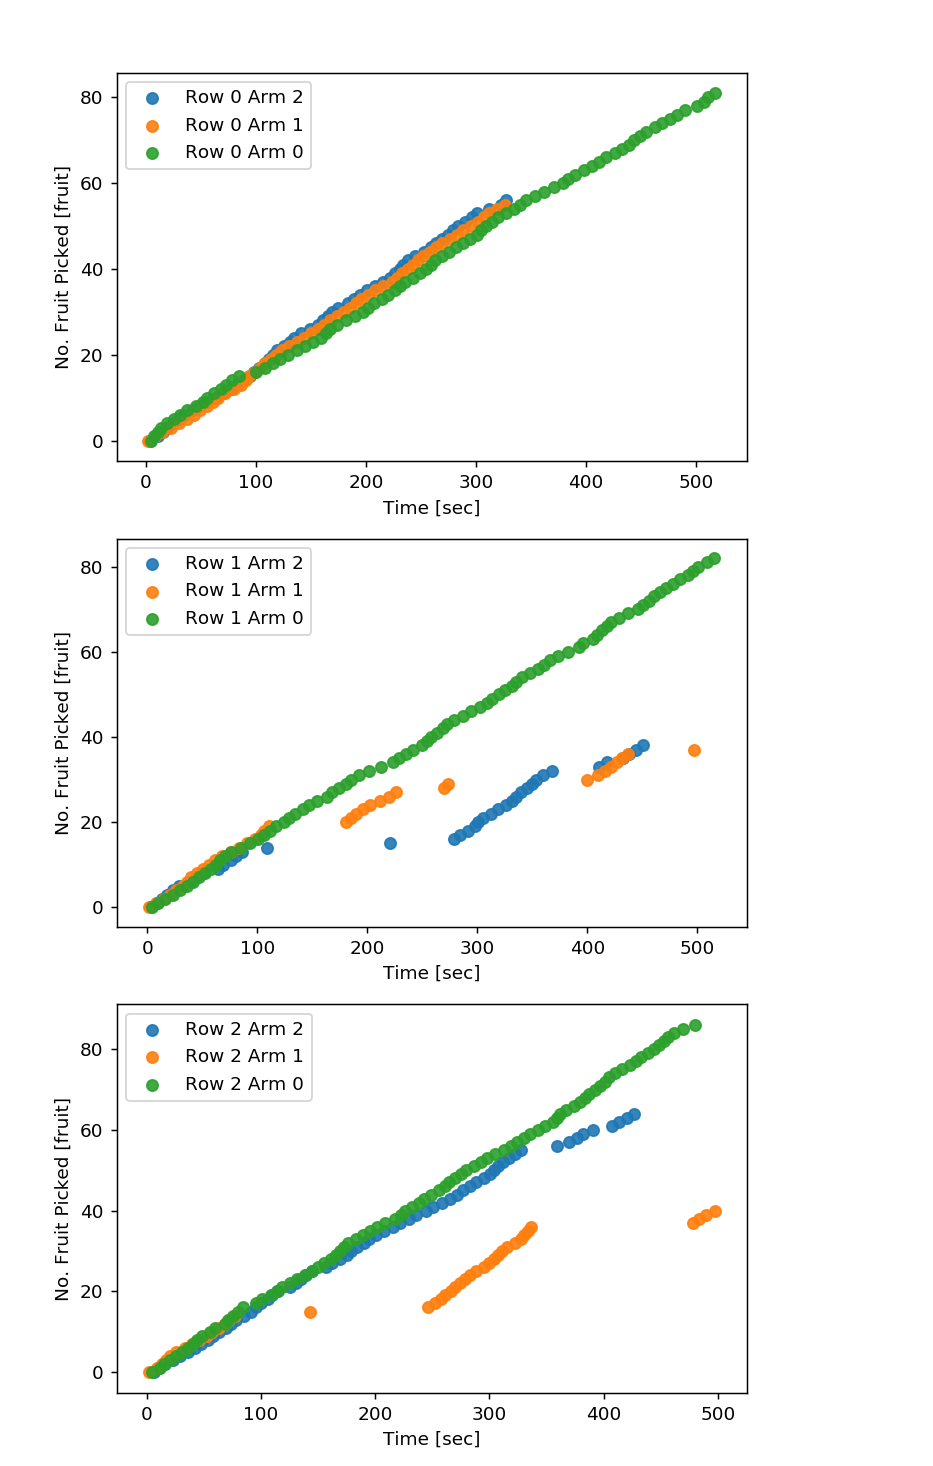

In [13]:
# Plot time versus number of fruit picked per arm
fig, ax = plt.subplots(num_row, figsize=(7, 11))

for rows in range(num_row):
    for manipulators in range((num_arms-1), -1, -1):
        time_apples = np.copy(a[rows,manipulators].pickData())
        apples      = range(np.shape(time_apples)[0])

        
        arm_label = "Row "+str(rows)+" Arm "+str(manipulators)
        
        ax[rows].scatter(time_apples, apples, alpha=0.9, label=arm_label)
        ax[rows].set_xlabel("Time [sec]")
        ax[rows].set_ylabel("No. Fruit Picked [fruit]")
#         ax[rows].set_title("No. of fruit picked versus time")
        ax[rows].legend(loc='upper left', ncol=1)
        
        fig.subplots_adjust(bottom=0.05, top=0.95, right=0.8)
        
        plt.show()
        
        

In [5]:
# analyze the % time each arm is in each state 
idle       = 0
pickingyz  = 0
pickingx   = 0
grabbing   = 0
retracting = 0
unloading  = 0

tot_num_arms = num_arms*num_row

state_step = 0
 
state_data = np.zeros((tot_num_arms, len(arm_states)))

# obtain the state for each arm
for time_step in arm_states:  # has all the arms' states at each loop of the main code
    for arm_num in time_step: # for each arm in that time step
        state_data[arm_num[0],state_step] = arm_num[1]

        if state_data[arm_num[0],state_step] == 0:
            idle       += 1
        elif state_data[arm_num[0],state_step] == 1:
            pickingyz  += 1
        elif state_data[arm_num[0],state_step] == 2:
            pickingx   += 1
        elif state_data[arm_num[0],state_step] == 3:
            grabbing   += 1
        elif state_data[arm_num[0],state_step] == 4:
            retracting += 1
        elif state_data[arm_num[0],state_step] == 5:
            unloading  += 1
       
    state_step += 1
            
idle_arm   = 0
pickyz_arm = 0
pickx_arm  = 0
grab_arm   = 0
retr_arm   = 0
unlo_arm   = 0

row_n = 0
arm_n = 0

# for plotting
idle_plot   = []
pickyz_plot = []
pickx_plot  = []
grab_plot   = []
retr_plot   = []
unlo_plot   = [] 


# for each arm take the state obtained using state_data, determine the state at each time point for each arm 
for i in range(tot_num_arms):
    for x in state_data[i]:
        if x == 0:
            idle_arm   += 1
        elif x == 1:
            pickyz_arm += 1
        elif x == 2:
            pickx_arm  += 1
        elif x == 3:
            grab_arm   += 1
        elif x == 4:
            retr_arm   += 1
        elif x == 5:
            unlo_arm   += 1
    
    # add them all together so that percentages can be calculated
    total = idle_arm + pickyz_arm + pickx_arm + grab_arm + retr_arm + unlo_arm
    
    # append the current arm's data to the plotting list
    idle_plot.append(idle_arm)
    pickyz_plot.append(pickyz_arm)
    pickx_plot.append(pickx_arm)
    grab_plot.append(grab_arm)
    retr_plot.append(retr_arm)
    unlo_plot.append(unlo_arm)
    
    arm_n += 1
    
    # used to determine which row corresponds to the specific arm
    if i%num_row == 0:
        row_n = math.floor(i/num_row)
        arm_n = 0
        
#     print("Arm", arm_n, "in row", row_n)
#     print("Idle:", idle_arm, "[unitless], Picking:", pick_arm, "[unitless], Retracting:", retr_arm, "[unitless], Unloading:", unlo_arm, "[unitless]")
#     print("Idle: {0:.4f}".format(idle_arm/total*100), "[%], Picking: {0:.4f}".format(pick_arm/total*100), "[%], Retracting: {0:.4f}".format(retr_arm/total*100), "[%], Unloading: {0:.4f}".format(unlo_arm/total*100), "[%]")
#     print("")
    
    # reset for the next run
    idle_arm   = 0.
    pickyz_arm = 0.
    pickx_arm  = 0.
    grab_arm   = 0.
    retr_arm   = 0.
    unlo_arm   = 0.


NameError: name 'num_arms' is not defined

In [15]:
## Functions to add grouping into the arm state percentage plot (and other future plots)
# https://stackoverflow.com/questions/19184484/how-to-add-group-labels-for-bar-charts-in-matplotlib

def mk_groups(data):
    # function takes a dictionary (or anything with an items() method, like collections.OrderedDict) and converts it to a data format that is then used to create the chart. It is basically a list
    try:
        newdata = data.items()
    except:
        return

    thisgroup = []
    groups = []
    for key, value in newdata:
        newgroups = mk_groups(value)
        if newgroups is None:
            thisgroup.append((key, value))
        else:
            thisgroup.append((key, len(newgroups[-1])))
            if groups:
                groups = [g + n for n, g in zip(newgroups, groups)]
            else:
                groups = newgroups
    return [thisgroup] + groups

def add_line(ax, xpos, ypos):
    # creates a vertical line in the subplot at the specified positions (in axes coordinates)
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_group_bar(ax, data):
    # takes a dictionary and creates the subplot with the labels beneath
    groups = mk_groups(data)
    xy = groups.pop()
    x, y = zip(*xy)
    ly = len(y)
    xticks = range(1, ly + 2)

    ax.set_xticks(xticks)
    ax.set_xticklabels(x)
    ax.set_xlim(.5, ly + .5)

    scale = 1. / ly
    for pos in range(ly + 1):
        add_line(ax, pos * scale, -.1)
        
    ypos = -.2
    while groups:
        group = groups.pop()
        pos = 0
        for label, rpos in group:
            lxpos = (pos + .5 * rpos) * scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale, ypos)
        ypos -= .1



<IPython.core.display.Javascript object>


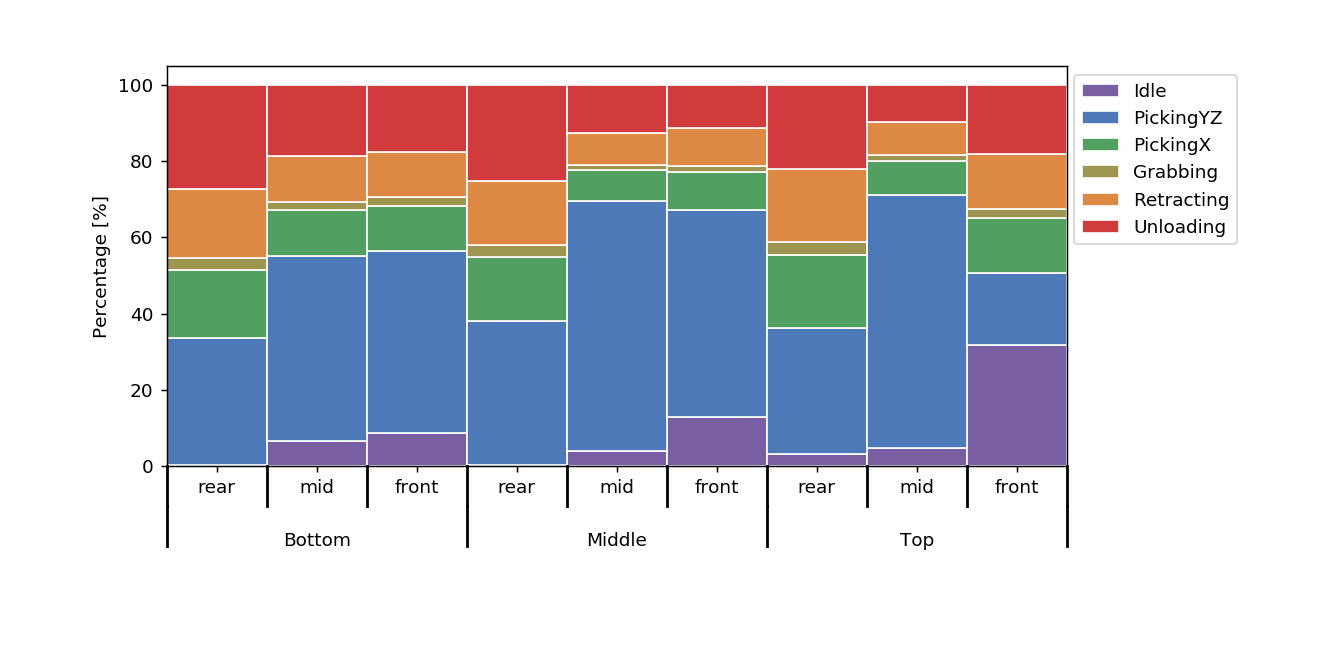

In [16]:
# % stacked bar plot
## https://chrisalbon.com/python/data_visualization/matplotlib_percentage_stacked_bar_plot/

data = {'Bottom':
           {'rear':0,
            'mid':1,
            'front':2
           },
#         'Middle Bt':
#            {'rear':0,
#             'mid':1,
#             'front':2
#            },
#         'Middle Top':
#            {'rear':0,
#             'mid':1,
#             'front':2
#            },
        'Middle':
           {'rear':0,
            'mid':1,
            'front':2
           },
        'Top':
           {'rear':0,
            'mid':1,
            'front':2
           },
       }



# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))

# Set bar width at 1
bar_width = 1

# positions of the left bar-boundaries
bar_l = [i for i in range(1,len(idle_plot)+1)] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 
# print(tick_pos)

# Create the total steps per state
totals = [i+j+k+l+m+n for i,j,k,l,m,n in zip(idle_plot, pickyz_plot, pickx_plot, grab_plot, retr_plot, unlo_plot)]

# Create the percentage of the total steps for idle state
per_idle = [i / j * 100 for  i,j in zip(idle_plot, totals)]
# Create the percentage of the total steps for pickingyz state
per_pickyz = [i / j * 100 for  i,j in zip(pickyz_plot, totals)]
# Create the percentage of the total steps for pickingx state
per_pickx = [i / j * 100 for  i,j in zip(pickx_plot, totals)]
# Create the percentage of the total steps for grabbing state
per_grab = [i / j * 100 for  i,j in zip(grab_plot, totals)]
# Create the percentage of the total steps for retracting state
per_retr = [i / j * 100 for  i,j in zip(retr_plot, totals)]
# Create the percentage of the total steps for unloading state
per_unlo = [i / j * 100 for  i,j in zip(unlo_plot, totals)]

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using idle data
       per_idle, 
       # labeled 
       label='Idle', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#6B4C9A',
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_pickyz, 
       # with per_idle
       bottom=per_idle, 
       # labeled 
       label='PickingYZ', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#396AB1', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_pickx, 
       # with per_idle
       bottom=[i+j for i,j in zip(per_idle, per_pickyz)], 
       # labeled 
       label='PickingX', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#3E9651', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

ax.bar(bar_l, 
       # using picking data
       per_grab, 
       # with per_idle
       bottom=[i+j+k for i,j,k in zip(per_idle, per_pickyz, per_pickx)], 
       # labeled 
       label='Grabbing', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#948B3D', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using retracting data
       per_retr, 
       # with per_idle and per_pick on bottom
       bottom=[i+j+k+l for i,j,k,l in zip(per_idle, per_pickyz, per_pickx, per_grab)], 
       # labeled 
       label='Retracting',
       # with alpha
       alpha=0.9, 
       # with color
       color='#DA7C30', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using retracting data
       per_unlo, 
       # with all other percents on bottom
       bottom=[i+j+k+l+m for i,j,k,l,m in zip(per_idle, per_pickyz, per_pickx, per_grab, per_retr)], 
       # labeled 
       label='Unloading',
       # with alpha
       alpha=0.9, 
       # with color
       color='#CC2529', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )


ax.set_ylabel("Percentage [%]")

# grouping x-axis values
label_group_bar(ax, data)
f.subplots_adjust(bottom=0.3, top=0.9, right=0.8)
# f.subplots_adjust()

# rotate axis labels
# plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')

# create legend outside of plot
# see https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot/43439132#43439132
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', ncol=1)

# shot plot
plt.show()

In [17]:
# total values 
idle_all = idle*dt
pickyz_all = pickingyz*dt
pickx_all = pickingx*dt
grab_all = grabbing*dt
retract_all = retracting*dt
unload_all = unloading*dt

# print("total time spent idle for all arms:", idle_all, "sec")
# print("total time spent picking in yz axis for all arms:", pickyz_all, "sec")
# print("total time spent picking in x axis for all arms:", pickx_all, "sec")
# print("total time spent grabbing fruit for all arms:", grab_all, "sec")
# print("total time spent retracting for all arms:", retract_all, "sec")
# print("total time spent unloading for all arms:", unload_all, "sec")

total_time = (idle_all + pickyz_all + pickx_all + grab_all + retract_all + unload_all) # / (num_arms*num_row_arms)

# print("total time all arms:", total_time, "sec") 
# print("Which totals internal simulator seconds multiplied by number of arms")

percent_idle    = (idle_all / total_time) * 100
percent_pickyz  = (pickyz_all / total_time) * 100
percent_pickx   = (pickx_all / total_time) * 100
percent_grab    = (grab_all / total_time) * 100
percent_retract = (retract_all / total_time) * 100
percent_unload  = (unload_all / total_time) * 100

print("For all arms:")
print("Total percent time idle:             {0:.2f}".format(percent_idle), "%")
print("Total percent picking fruit          {0:.2f}".format(percent_pickyz+percent_pickx+percent_grab), "%")
print("---------------------------------------------")
print("Picking fruit is broken up into:")
print("Total percent time picking in y, z:  {0:.2f}".format(percent_pickyz), "%")
print("Total percent time picking in x:      {0:.2f}".format(percent_pickx), "%")
print("Total percent time grabbing fruit     {0:.2f}".format(percent_grab), "%")
print("---------------------------------------------")
print("Total percent time retracting        {0:.2f}".format(percent_retract), "%")
print("Total percent time unloading         {0:.2f}".format(percent_unload), "%")


For all arms:
Total percent time idle:             7.98 %
Total percent picking fruit          60.70 %
---------------------------------------------
Picking fruit is broken up into:
Total percent time picking in y, z:  45.14 %
Total percent time picking in x:      13.22 %
Total percent time grabbing fruit     2.34 %
---------------------------------------------
Total percent time retracting        13.23 %
Total percent time unloading         18.08 %


num runs 52001


<IPython.core.display.Javascript object>


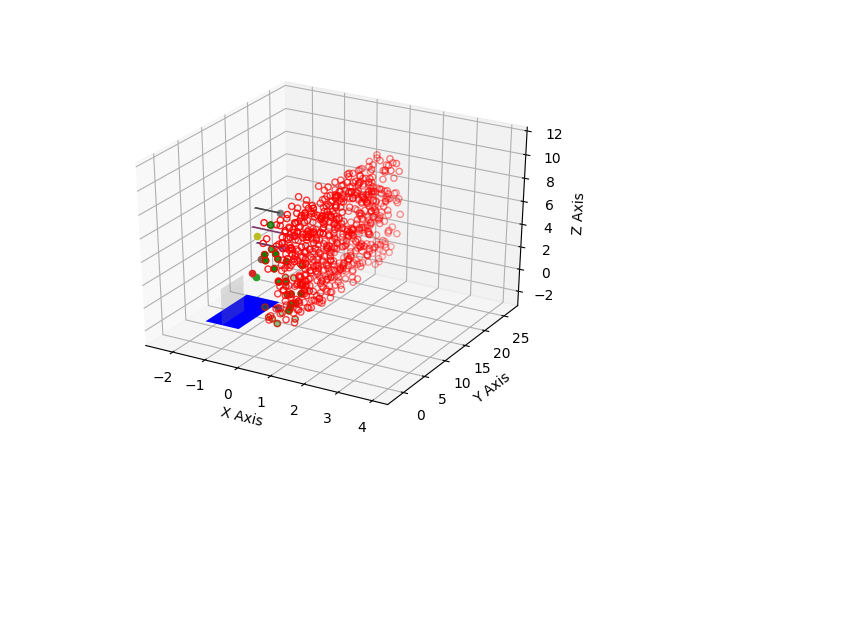

KeyboardInterrupt: 

In [19]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

for run in range(runs):
    time_of_loop = t[run]
    
    if run % 60 == 0:
        ax.clear()
        
        for rows in range(num_row):
            # check if any fruit was picked at this time
            try:        
                # is the if needed when there is a try? => yup, otherwise the points appear at random times
                if fruit_removal[rows][3, index_rem[rows]] < time_of_loop:
                    # add the fruit index to be "removed"
                    index_rem[rows] += 1
            except IndexError:
                print("** Index grew faster than it should have? **")
                print("Index to remove:", index_rem[rows], "in row:", rows, "time:", time_of_loop)
                print("current time value of fruit_removal:", fruit_removal[rows][3, index_rem[rows]-1])
        
        ax.scatter(fruit.sortedFruit[0,:], fruit.sortedFruit[1,:], fruit.sortedFruit[2,:], facecolors='none', edgecolors='r')
        
        for rows in range(num_row):
            ax.scatter(fruit_removal[rows][0,:index_rem[rows]], fruit_removal[rows][1,:index_rem[rows]], fruit_removal[rows][2,:index_rem[rows]], c='g', marker='o')
            
        q_vehicle = [qv0[run], qv1[run]]
        dr.drawRect(ax, q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(ax, left_edge[run], back_edge[run], front_edge[run], a[0,0].z_edges_f)
    
        # draw cyliders for the extending arms
        for rows in range(num_row):
            for count in range(num_arms):
                ax.scatter(a[rows,count].qax[run], a[rows,count].qay[run], a[rows,count].qaz[run])
                # need to switch this to a cylinder
                xc, yc, zc = dr.drawArmCylinder(a[rows,count].qay[run], a[rows,count].qaz[run], a[rows,count].q_f[0], a[rows,count].qax[run])
                ax.plot_surface(xc, yc, zc)


        ax.set_xlim(fruit_row_ed-3, fruit_row_tk+3)
        ax.set_zlim(fruit_row_bt-3, fruit_row_tp+3)
        
        ax.set_ylim(fruit_row_st-3, fruit_row_end+3)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.005)
       
    
fig.show()



In [29]:
# need to print all the fruit that remains unpicked
miss  = 0
sched = 0 
pick  = 0

# prints all the fruit that has not been picked
for x in range(len(fruit.sortedFruit[1])):
    if fruit.sortedFruit[:,x][3] == 0: 
        miss += 1
#         print(x)
    elif fruit.sortedFruit[:,x][3] == 1:
        sched += 1
#         print(x)
    elif fruit.sortedFruit[:,x][3] == 2:
        pick += 1
        
# should plot the three different groups to see where they are
print("Total missed fruit:", miss)
print("Total scheduled, but not picked fruit:", sched)
print("Total picked fruit:", pick)

print("")
print("They add up to:", miss+sched+pick)
print("Total unpicked fruit:", miss+sched)

per = 100* (miss+sched) / (miss+sched+pick)

print("Percent missed fruit: {0:.2f}".format(per), "%")

Total missed fruit: 45
Total scheduled, but not picked fruit: 85
Total picked fruit: 545

They add up to: 675
Total unpicked fruit: 130
Percent missed fruit: 19.26 %
